EGG synthesis

Model: Transformer might not be necessary, since the input and output are of the same length. A simple feed-forward network might be enough.

X: (a)raw audio signal, 16kHz, (batch_size, time_frames)
   (b)spectrograms, 16kHz, (batch_size, frequency_bins, time_frames)
   (c)MFCCs,  16kHz, (batch_size, frequency_bins, time_frames)
Y: (a) EGG signal waveform, 16kHz
   (b) metrics, 50Hz
   (c) Fourier descriptors, 50Hz

Loss function: MSE works fine with test, but not others
               Cosine similarity works fine with mapping the shape, but not the amplitude
               DTW works bad here.

Comments:
since I use metrics as reference, it's probably better to use metrics as output as well.

Environment Setup

In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import librosa
import itertools
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, Dataset
import models
import importlib
importlib.reload(models)
from models import *
from torch.utils.tensorboard import SummaryWriter


# hyperparameters
samplerate = 16000
num_epochs = 300
hidden_size = 256
second_hidden_size = 256
third_hidden_size = 256
learning_rate = 0.001
# the f0 range is from 50 to 500 Hz, it should cover the longest f0 in the dataset, so 50Hz=0.02s
segment_length_in_seconds = 0.02
# noise level
segment_length_in_samples = int(segment_length_in_seconds * samplerate)
batch_size = 4
representation_type = 'Mel'





Data set building

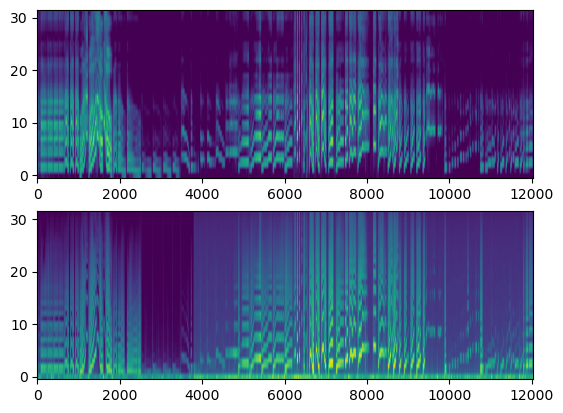

In [17]:
raw_wav = librosa.load('F01_VRP_C_Voice_EGG.wav', sr=samplerate, mono=False)[0]
input_wav = raw_wav[0]
target_wav = raw_wav[1]

# convert the raw wav to mel spectrogram
mel_input = librosa.power_to_db(librosa.feature.melspectrogram(y=input_wav, sr=samplerate, n_mels=32))
mel_target = librosa.power_to_db(librosa.feature.melspectrogram(y=target_wav, sr=samplerate, n_mels=32))

import numpy as np

def reshape_mel_spectrogram(mel_input, num_frames):
    """
    Reshape a Mel spectrogram from (n_mels, total_samples) to (num_samples, num_frames, n_mels).

    Args:
        mel_input (numpy.ndarray): The Mel spectrogram with shape (n_mels, total_samples).
        num_frames (int): The desired number of frames (time steps) for each sample.

    Returns:
        numpy.ndarray: The reshaped Mel spectrogram with shape (num_samples, num_frames, n_mels).
    """
    n_mels, total_samples = mel_input.shape
    # Ensure that the total number of samples is divisible by the number of frames, if not, delete the last frame
    mel_input = mel_input[:, :-(total_samples % num_frames)]

    # Calculate the number of samples we'll end up with after the reshape
    num_samples = total_samples // num_frames

    # Reshape the Mel spectrogram
    reshaped_mel_input = mel_input.T.reshape(num_samples, num_frames, n_mels)

    return reshaped_mel_input

num_frames = 100  # This is an example, adjust to your actual desired frame count
reshaped_mel_input = reshape_mel_spectrogram(mel_input, num_frames)
reshaped_mel_target = reshape_mel_spectrogram(mel_target, num_frames)

# plot the mel spectrogram
plt.figure()
plt.subplot(2, 1, 1)
plt.imshow(mel_input, aspect='auto', origin='lower')
plt.subplot(2, 1, 2)
plt.imshow(mel_target, aspect='auto', origin='lower')
plt.show()

import torch
from torch.utils.data import Dataset
import numpy as np

class VoiceDataset(Dataset):
    def __init__(self, input_mel_specs, target_mel_specs):
        """
        Initializes the dataset with input and target Mel spectrograms.

        Args:
        input_mel_specs (numpy.ndarray): A 3D numpy array of shape (num_samples, num_frames, n_mels)
                                         containing the Mel spectrogram for the input audio.
        target_mel_specs (numpy.ndarray): A 3D numpy array of shape (num_samples, num_frames, n_mels)
                                          containing the Mel spectrogram for the target audio.
        """
        assert input_mel_specs.shape == target_mel_specs.shape, "Input and target spectrograms must have the same shape"
        
        self.input_mel_specs = input_mel_specs
        self.target_mel_specs = target_mel_specs

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return self.input_mel_specs.shape[0]

    def __getitem__(self, idx):
        """
        Returns the input and target Mel spectrogram for a given index.

        Args:
        idx (int): The index of the sample.

        Returns:
        Tuple[torch.Tensor, torch.Tensor]: The input and target Mel spectrograms as PyTorch tensors.
        """
        input_spec = torch.tensor(self.input_mel_specs[idx], dtype=torch.float32)
        target_spec = torch.tensor(self.target_mel_specs[idx], dtype=torch.float32)
        
        return input_spec, target_spec

# Assuming input_mel_specs and target_mel_specs are your datasets
dataset = VoiceDataset(reshaped_mel_input, reshaped_mel_target)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
# create the dataset
dataset = VoiceDataset(segment_length_in_samples)
# 1.load files, audio and EGG, choose the file type to load
wav_data = dataset.load_dataset('F01', samplerate)
# 2.consider representation, and segment the data
dataset.preprocess(wav_data, denoise=False, preprocess_type = representation_type)
# 3.other preprocess
# ...

train_segments, val_segments, test_segments = dataset.split_data(train_ratio=0.7, val_ratio=0.15)

# create the dataloader
train_loader = DataLoader(train_segments, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_segments, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_segments, batch_size=batch_size, shuffle=False)

# check the shape and number of the input, target
for i, (input_tensor, target_tensor) in enumerate(train_loader):
    print(input_tensor.shape)
    print(target_tensor.shape)
    print(f"Total number of batches: {len(train_loader)}")
    print(f"Total number of samples: {len(train_loader.dataset)}")
    break

# # plot the input and target mel spectrogram
plt.figure()
plt.subplot(2, 1, 1)
plt.imshow(input_tensor[2].numpy(), aspect='auto')
plt.title('Input Mel spectrogram')
plt.subplot(2, 1, 2)
plt.imshow(target_tensor[2].numpy(), aspect='auto')
plt.title('Target Mel spectrogram')
plt.show()

In [ ]:
# for mel spectrogram
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False)
        self.decoder = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=False) 
        self.fc = nn.Linear(hidden_size, output_size)  # Maps hidden state to output size (Mel frequency bands)
        self.dropout = nn.Dropout(dropout_prob)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Maps fc output to decoder input size (1)
        self.decoder_input_layer = nn.Linear(output_size, hidden_size)  # Correct the mapping size

    def forward(self, x):
        # Reshape input to [seq_len, batch_size, input_size]
        x = x.transpose(0, 1)

        # Encoding
        encoder_outputs, (hidden, cell) = self.encoder(x)

        # Prepare the first input to the decoder which will be the last hidden state of the encoder
        decoder_input = hidden[-1]  # Take the last layer's hidden state for all batches

        # Initialize the decoder hidden state as the last encoder hidden state
        decoder_hidden = hidden
        decoder_cell = cell

        # Decoding
        decoder_outputs = []
        for t in range(x.size(0)):  # Iterate over time steps
            # Decode step by step
            decoder_output, (decoder_hidden, decoder_cell) = self.decoder(
                decoder_input.unsqueeze(0), (decoder_hidden, decoder_cell))
            out = self.fc(self.dropout(decoder_output.squeeze(0)))
            decoder_outputs.append(out)
            # Transform the output size to match the decoder input size using the decoder input layer
            decoder_input = self.decoder_input_layer(out)

        # Stack outputs along the sequence dimension
        outputs = torch.stack(decoder_outputs, dim=0).transpose(0, 1)

        return outputs


Training

In [ ]:
# FNN training
model = LSTM(input_size=32, hidden_size=hidden_size, second_hidden_size=second_hidden_size,
                             output_size=32, dropout_prob=0.2)
log_name = f'{type(model).__name__}_{representation_type}_bs{batch_size}'
writer = SummaryWriter('runs/experiment_name')

sample_input = torch.randn(batch_size, segment_length_in_samples)
writer.add_graph(model, sample_input)

tensorboard_log_config(writer, model, representation_type, samplerate, segment_length_in_seconds, batch_size)
trained_model = train_model(writer, model, train_loader, val_loader, num_epochs, learning_rate)
writer.close()


In [ ]:
# MEL spectrogram training
model = Seq2SeqLSTM(input_size=n_mels, hidden_size=hidden_size, num_layers=3, output_size=n_mels, dropout_prob=0.2)

# Move the model to the appropriate device (e.g., CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)

# Early stopping parameters
best_val_loss = float('inf')
patience = 20
patience_counter = 0

# Lists for storing metrics
train_losses = []
val_losses = []
lr_rates = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Logging shapes for the first epoch
        if epoch == 0 and i == 0:
            print(f"Epoch {epoch + 1}, Batch {i + 1}: Input Shape - {inputs.shape}, Target Shape - {targets.shape}")

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Learning rate scheduler step and log current LR
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    lr_rates.append(current_lr)

    print(f"Epoch {epoch + 1}: Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Learning Rate: {current_lr}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lr_rates, label='Learning Rate')
plt.title("Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.legend()

plt.show()

Prediction

In [ ]:
# predict
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets).item()
        print(f"Test Loss: {loss:.4f}")

# plot the random predicted wav for visualization
plt.figure(figsize=(16, 4))
random_index = random.randint(0, len(outputs) - 1)
plt.plot(outputs[random_index].cpu().numpy())
plt.title('Predicted')
plt.show()
plt.figure(figsize=(16, 4))
plt.plot(targets[random_index].cpu().numpy())
plt.title('Target')
plt.show()

# close plt
plt.close('all')

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'outputs' is your predicted Mel spectrogram in dB with shape [batch_size, n_mels, time_steps]
# Convert it back to the linear scale
mel_spec_predicted = librosa.db_to_power(outputs[0].cpu().numpy())

# Inverse Mel transformation
stft_predicted = librosa.feature.inverse.mel_to_stft(mel_spec_predicted)

# Apply Griffin-Lim algorithm to reconstruct the phase information
waveform_predicted = librosa.griffinlim(stft_predicted)

# Plot the predicted waveform for visualization
plt.figure(figsize=(16, 4))
plt.plot(waveform_predicted)
plt.title('Predicted Waveform')
plt.show()

# The same steps would apply to the target if it's also a Mel spectrogram


In [ ]:
# MSE loss
# predict
model.eval()
test_loss = 0
for inputs, targets in test_loader:
    with torch.no_grad():
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')



# turn to original wav
outputs = outputs.detach().numpy()
targets = targets.detach().numpy()
outputs = outputs.reshape(-1)
targets = targets.reshape(-1)

# draw the waveform
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(outputs[0:300], label='output')
plt.plot(targets[0:300], label='target')
plt.legend()
plt.show()



In [ ]:
# pearson correlation for target and output
from scipy.stats import pearsonr
corr, _ = pearsonr(outputs, targets)
print('Pearsons correlation: %.3f' % corr)